In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [7]:
#data transformations
data_transforms = {
    'train': transforms.Compose([
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      #normalize the images, set the mean and std
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
#load train and val data
data_dir = '../input/ant-and-bee/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True, num_workers = 4)
               for x in ['train', 'val']}

In [9]:
#set gpu device to store the tensors, if none use gpu
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(dataset_sizes)
print(device)

{'train': 244, 'val': 153}
cuda:0


In [10]:
#function to show images
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp);
  if title is not None:
    plt.title(title);


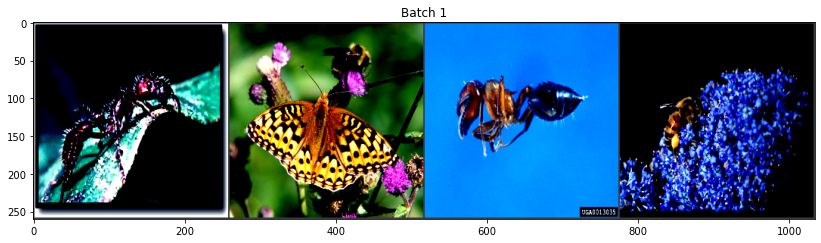

In [11]:
#show sample batch of images
images, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images)

imshow(out, 'Batch 1')

In [12]:
#create a function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):

  since = time.time()

  #create a copy of current model
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  #run training
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('=' *20)

    for phase in ['train', 'val']:
      #set the model
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0
    
      #iterate through the data
      for inputs, labels in dataloaders[phase]:
        #get the input and labels then point them to gpu memory
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #zero the gradients
        optimizer.zero_grad()
        #track the history if training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            #get the new gradients
            loss.backward()
            #update the weights
            optimizer.step()
        
        #trach the loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()
    
      #compute mean loss & accuracy 
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
      
      #get the best model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  #compute time elapsed
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy: {}'.format(best_acc))
  
  #set the best model then return it
  model.load_state_dict(best_model_wts)
  return model


In [13]:
#Transfer Learning ResNet
model_conv = models.resnet18(pretrained=True)

#freeze the pre-trained weights on convolutional layer
for param in model_conv.parameters():
  param.requires_grad = False

#classifier
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

#set the gpu
model_conv = model_conv.to(device)
#set sgd as optimizer & get a loss function
criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [14]:
#train the model
model_conv = train_model(model_conv, criterion_conv, optimizer_conv, exp_lr_scheduler)

NameError: name 'time' is not defined

In [ ]:
#get a sample image for testing
images, labels = next(iter(dataloaders['val']))
samp_image = images[0]

In [ ]:
model_conv(samp_image.view(1,3,256,256).to(device))

In [ ]:
#function to show images
def imshow(inp, title = None):
  #copy the image to cpu
  inp = inp.to('cpu')
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp);
  if title is not None:
    plt.title(title, fontsize=20);

def predict(img, model):
    pred_img = img.view(1,3,256,256).to(device)
    pred = torch.max(model(pred_img),1)[1]
    imshow(img, classes[pred].capitalize())


In [ ]:
#show prediction
predict(samp_image, model_conv)